cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.43e+00 | test_loss: 8.49e+00 | reg: 1.60e+01 | : 100%|█| 100/100 [00:06<00:00, 16.01


saving model version 0.1
MAE: 6.1430
MSE: 72.1233
MAPE: 6.0369
R²: 0.4534
RMSE: 8.4925
fixing (0,0,0) with log10, r2=1.0000001192092896, c=1
fixing (0,0,1) with log10, r2=1.0000001192092896, c=1
fixing (0,0,2) with log10, r2=0.9999946355819702, c=1
fixing (0,1,0) with x, r2=0.9991024136543274, c=1
fixing (0,1,1) with x, r2=0.9999671578407288, c=1
fixing (0,1,2) with x, r2=0.9998337626457214, c=1
fixing (0,2,0) with cos, r2=0.9999974966049194, c=2
fixing (0,2,1) with sin, r2=0.9999995231628418, c=2
fixing (0,2,2) with sin, r2=0.9999984502792358, c=2
fixing (1,0,0) with 0, r2=0.0, c=0
fixing (1,1,0) with x, r2=1.000000238418579, c=1
fixing (1,2,0) with x, r2=1.0000004768371582, c=1
saving model version 0.2


0.137*x_2 - 4.72*log10(0.541*x_1 + 0.899) - 12.684*log10(1.2*x_1 + 8.597) - 0.164*sin(6.236*x_3 - 4.644) + 0.227*sin(9.316*x_3 - 4.6) + 103.824

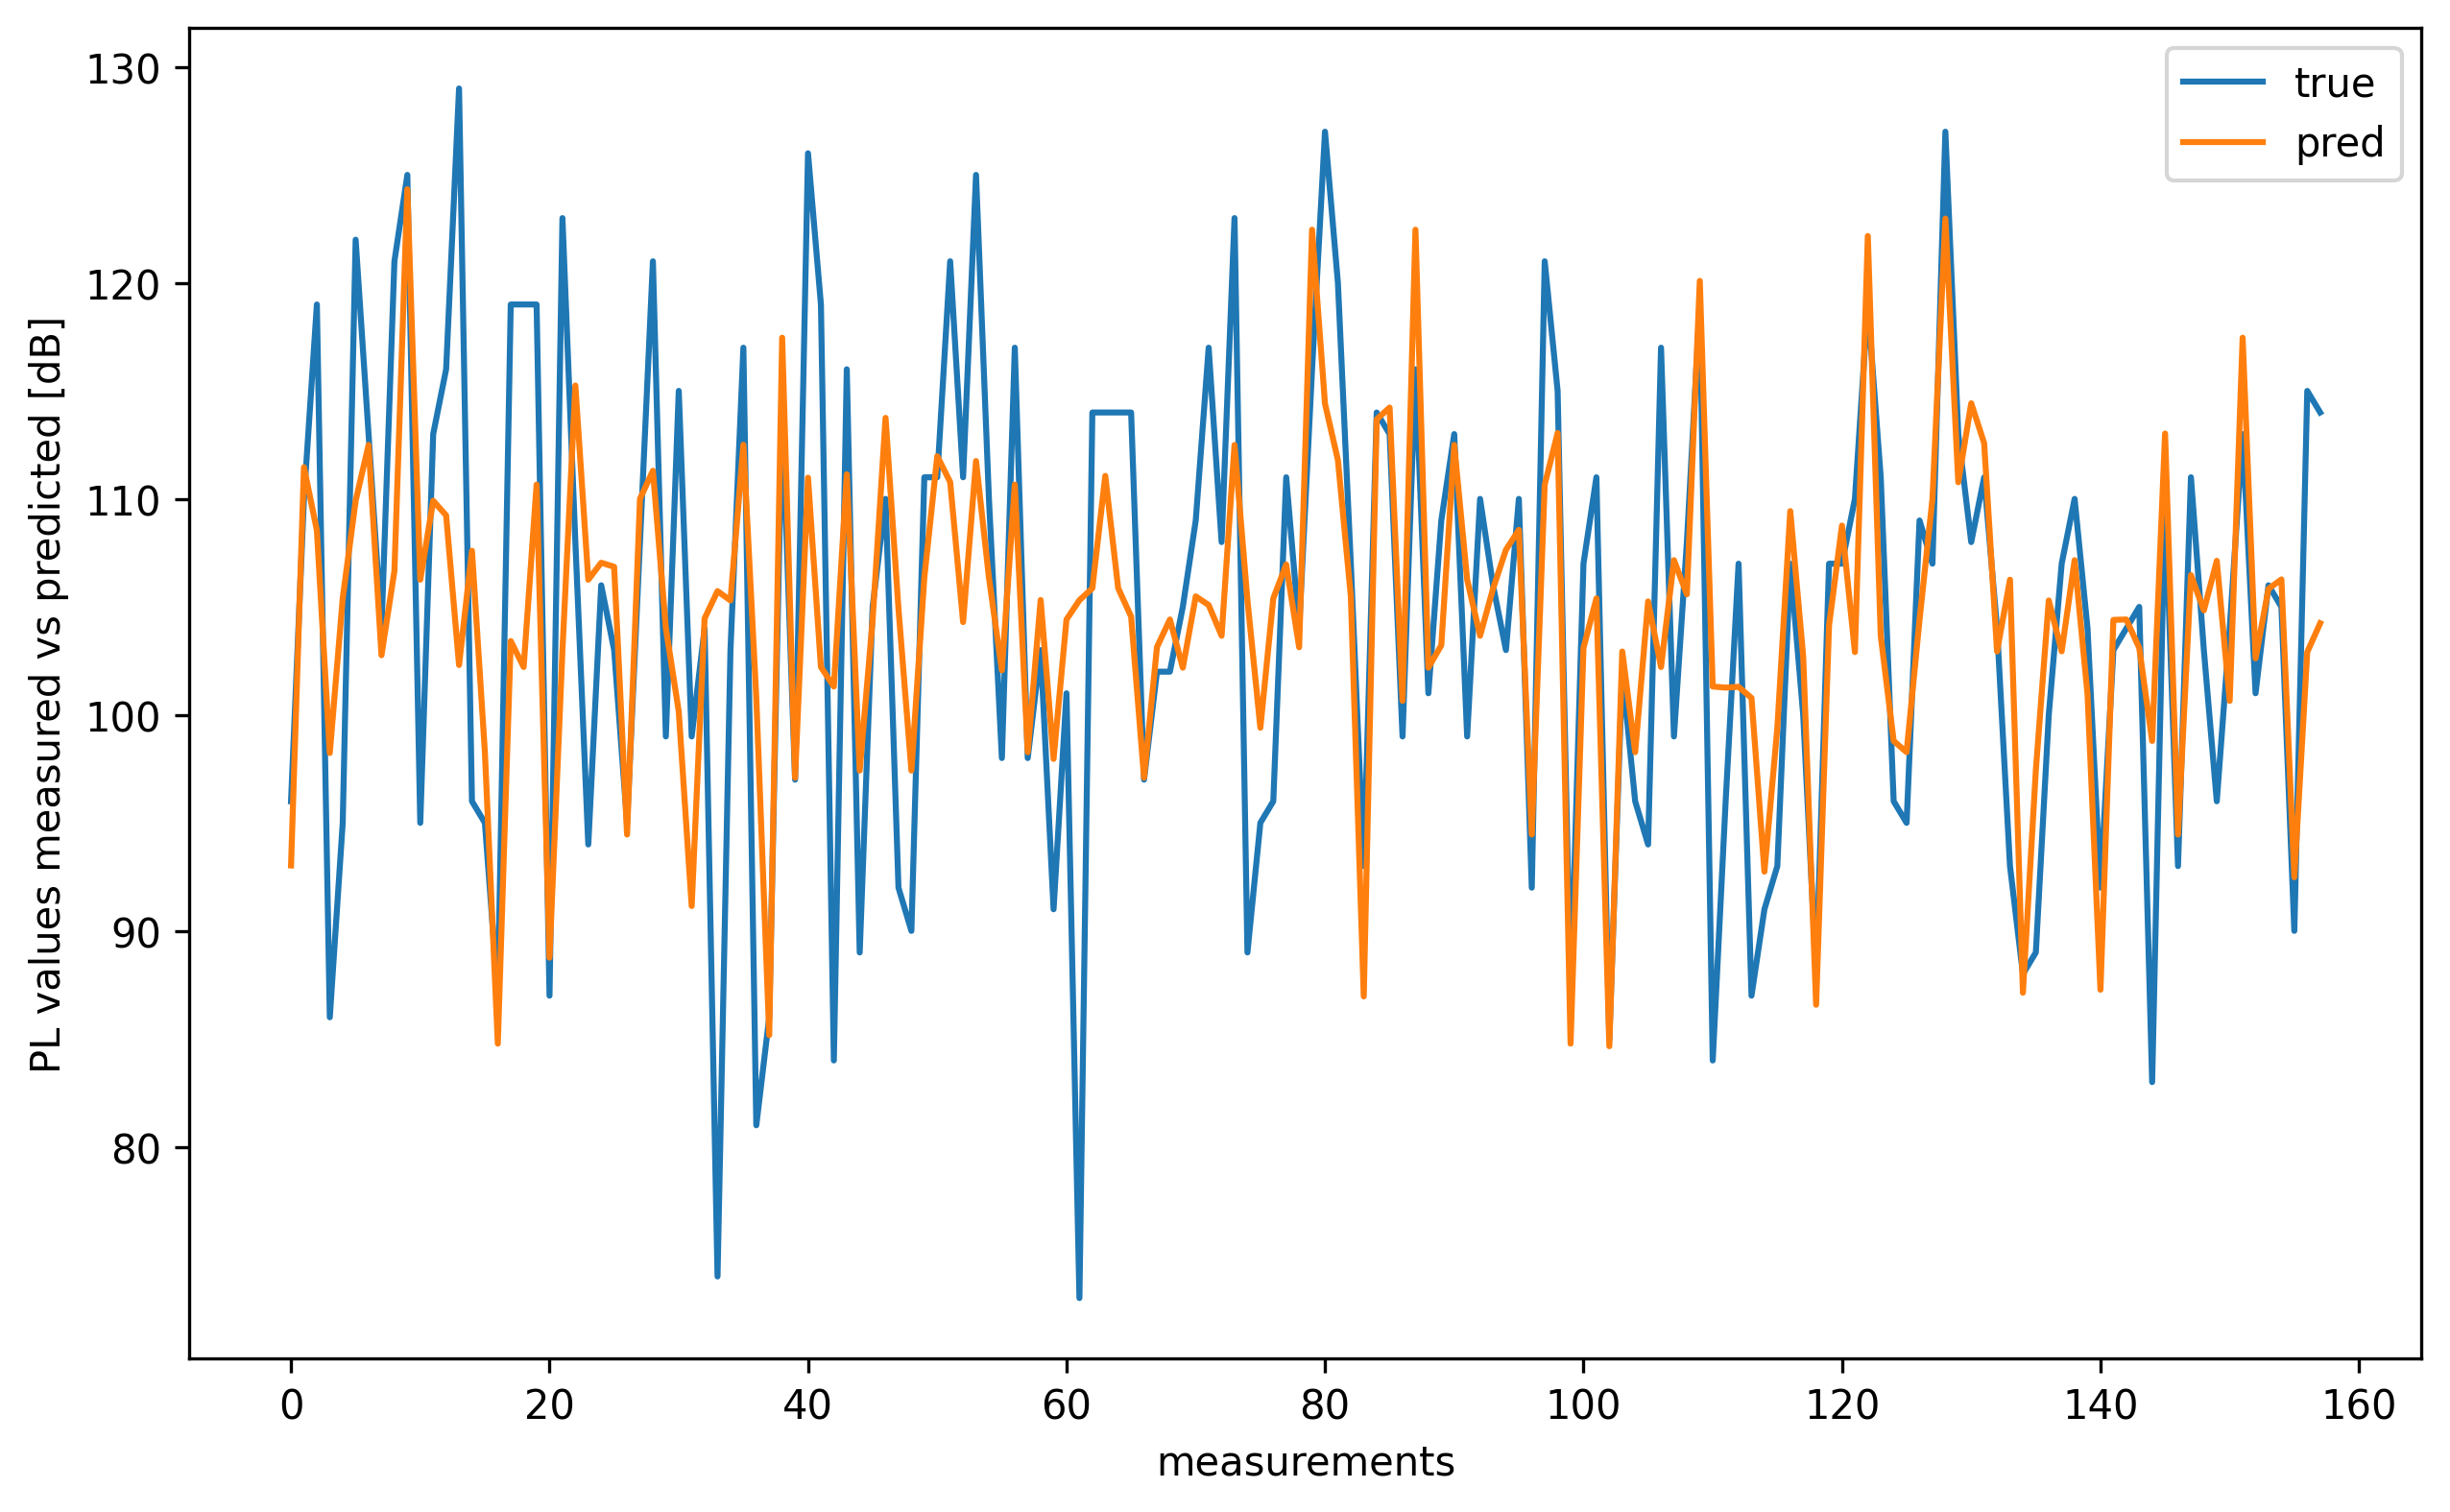

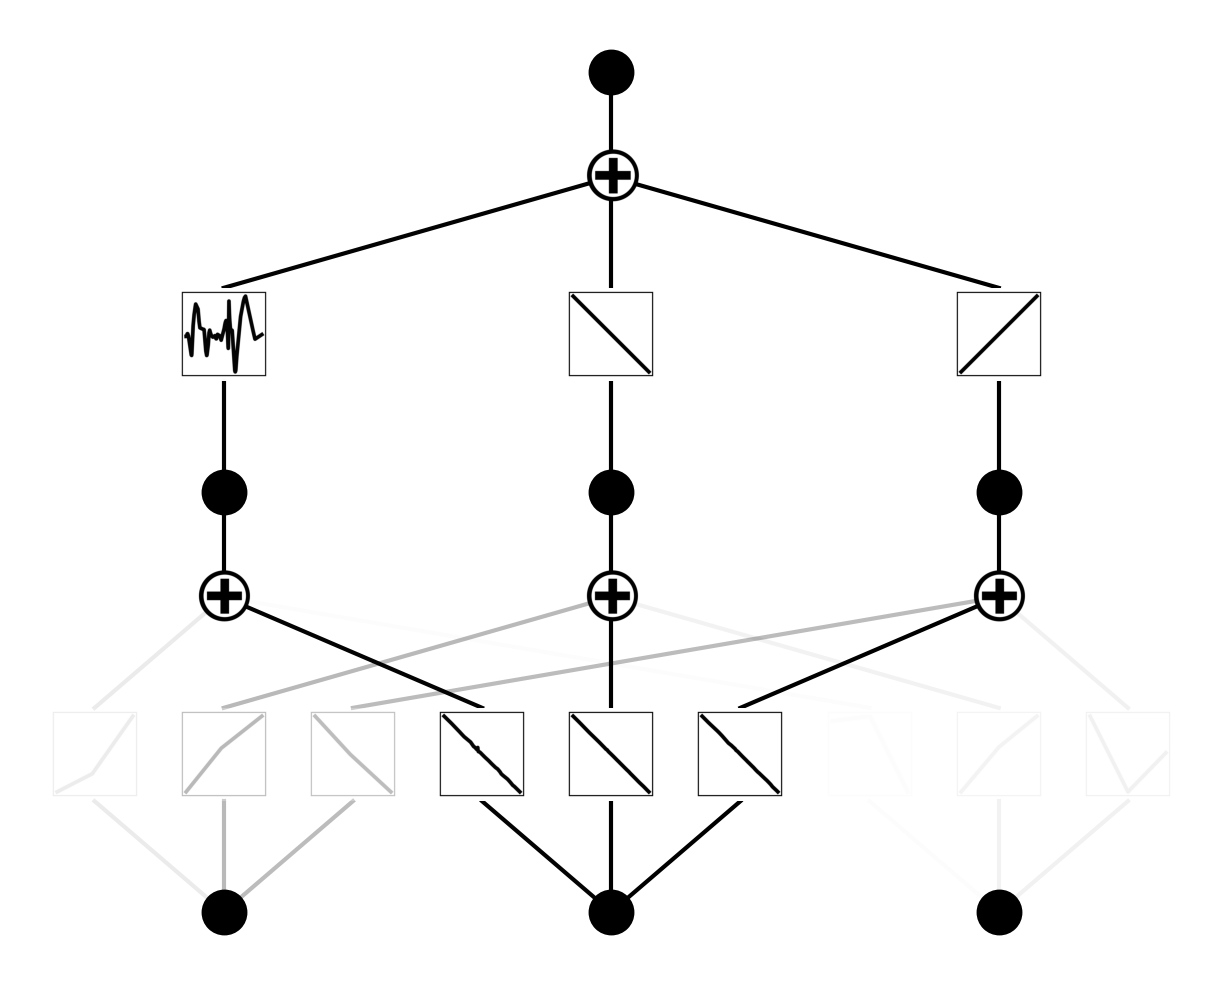

In [1]:

from kan import *
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def eval_kan(model_kan, f, test_data):
    y_true = test_data['test_label']
    with torch.no_grad():
        y_pred = model_kan(test_data['test_input'])
        
    y_true = y_true.detach().cpu().numpy().ravel()
    y_pred = y_pred.detach().cpu().numpy().ravel()
    time = range(len(y_true))

    # Plot the training and test losses.
    plt.plot(time, y_true)
    plt.plot(time, y_pred)
    if f is not nan:
        y_symbolic = f(test_data['test_input'])
        plt.plot(time, y_symbolic)
        plt.legend(['true', 'pred', 'symbolic'])
    else:
        plt.legend(['true', 'pred'])
    plt.ylabel('PL values measured vs predicted [dB]')
    plt.xlabel('measurements')


    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    mape_frac = mean_absolute_percentage_error(y_true, y_pred)
    mape = mape_frac * 100
    
    # Print results
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return mse, rmse, mae, mape, r2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gids_steps_lambda_loss(gids_size, steps, lam, metric, metric_name):
    """
    Plots a 3D scatter of gids_size vs steps vs train_loss, 
    with point color representing lambda.
    
    Parameters:
    - gids_size: array-like of shape (N,)
    - steps: array-like of shape (N,)
    - lam: array-like of shape (N,)
    - train_loss: array-like of shape (N,)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(gids_size, steps, lam, c=metric)
    
    ax.set_xlabel('gids size')
    ax.set_ylabel('steps')
    ax.set_zlabel('lambda')
    
    plt.colorbar(sc, label='metric')
    plt.title('3D Scatter: gids size vs steps vs lambda (' + metric_name + ' as color)')
    plt.show()


# Read the data from the Excel file
indoor_data = pd.read_excel('csv_experiments.xlsx', sheet_name='Outdoor', header=0)

# Assuming `inputs` and `labels` are your raw data as numpy arrays
inputs = indoor_data[['hed', 'd', 'f']].values  # Input features (f and d)
labels = indoor_data['PL'].values    # Output labels 
train_input, test_input, train_label, test_label = train_test_split(
    inputs, labels, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
train_input = torch.tensor(train_input, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)

train_label = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
test_label = torch.tensor(test_label, dtype=torch.float32).unsqueeze(1)

# Prepare the dataset dictionary
dataset = {}
dataset['train_input'] = train_input
dataset['test_input'] = test_input
dataset['train_label'] = train_label
dataset['test_label'] = test_label

model = KAN(width=[3,3,1], grid=40, k=3, seed=42, device=device)

# this is the learnt KAN model (splines + edge weights)
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.02, lamb_entropy=2.);

eval_kan(model, nan, dataset)
model.plot()

# this is the symbolic approximation of the learnt splines with interpretable mathematical functions
add_symbolic('log10', torch.log10)
model.auto_symbolic()

ex_round(model.symbolic_formula()[0][0], 3)

MAE: 8.8493
MSE: 121.1726
MAPE: 8.6327
R²: 0.0817
RMSE: 11.0078


/var/folders/kp/ywhxwl8j55z_9fb901tc6x_w0000gp/T/ipykernel_21365/1102975724.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = lambda x: 0.137 * x[:, 1] - 4.72 * np.log10(0.541 * x[:, 0] + 0.899) - 12.684 * np.log10(1.2 * x[:, 0] + 8.597) - 0.164 * np.sin(6.236 * x[:, 2] - 4.644) + 0.227 * np.sin(9.316 * x[:, 2] - 4.6) + 103.824


(121.17257690429688,
 np.float64(11.007841609702462),
 8.84926986694336,
 8.632708340883255,
 0.08168846368789673)

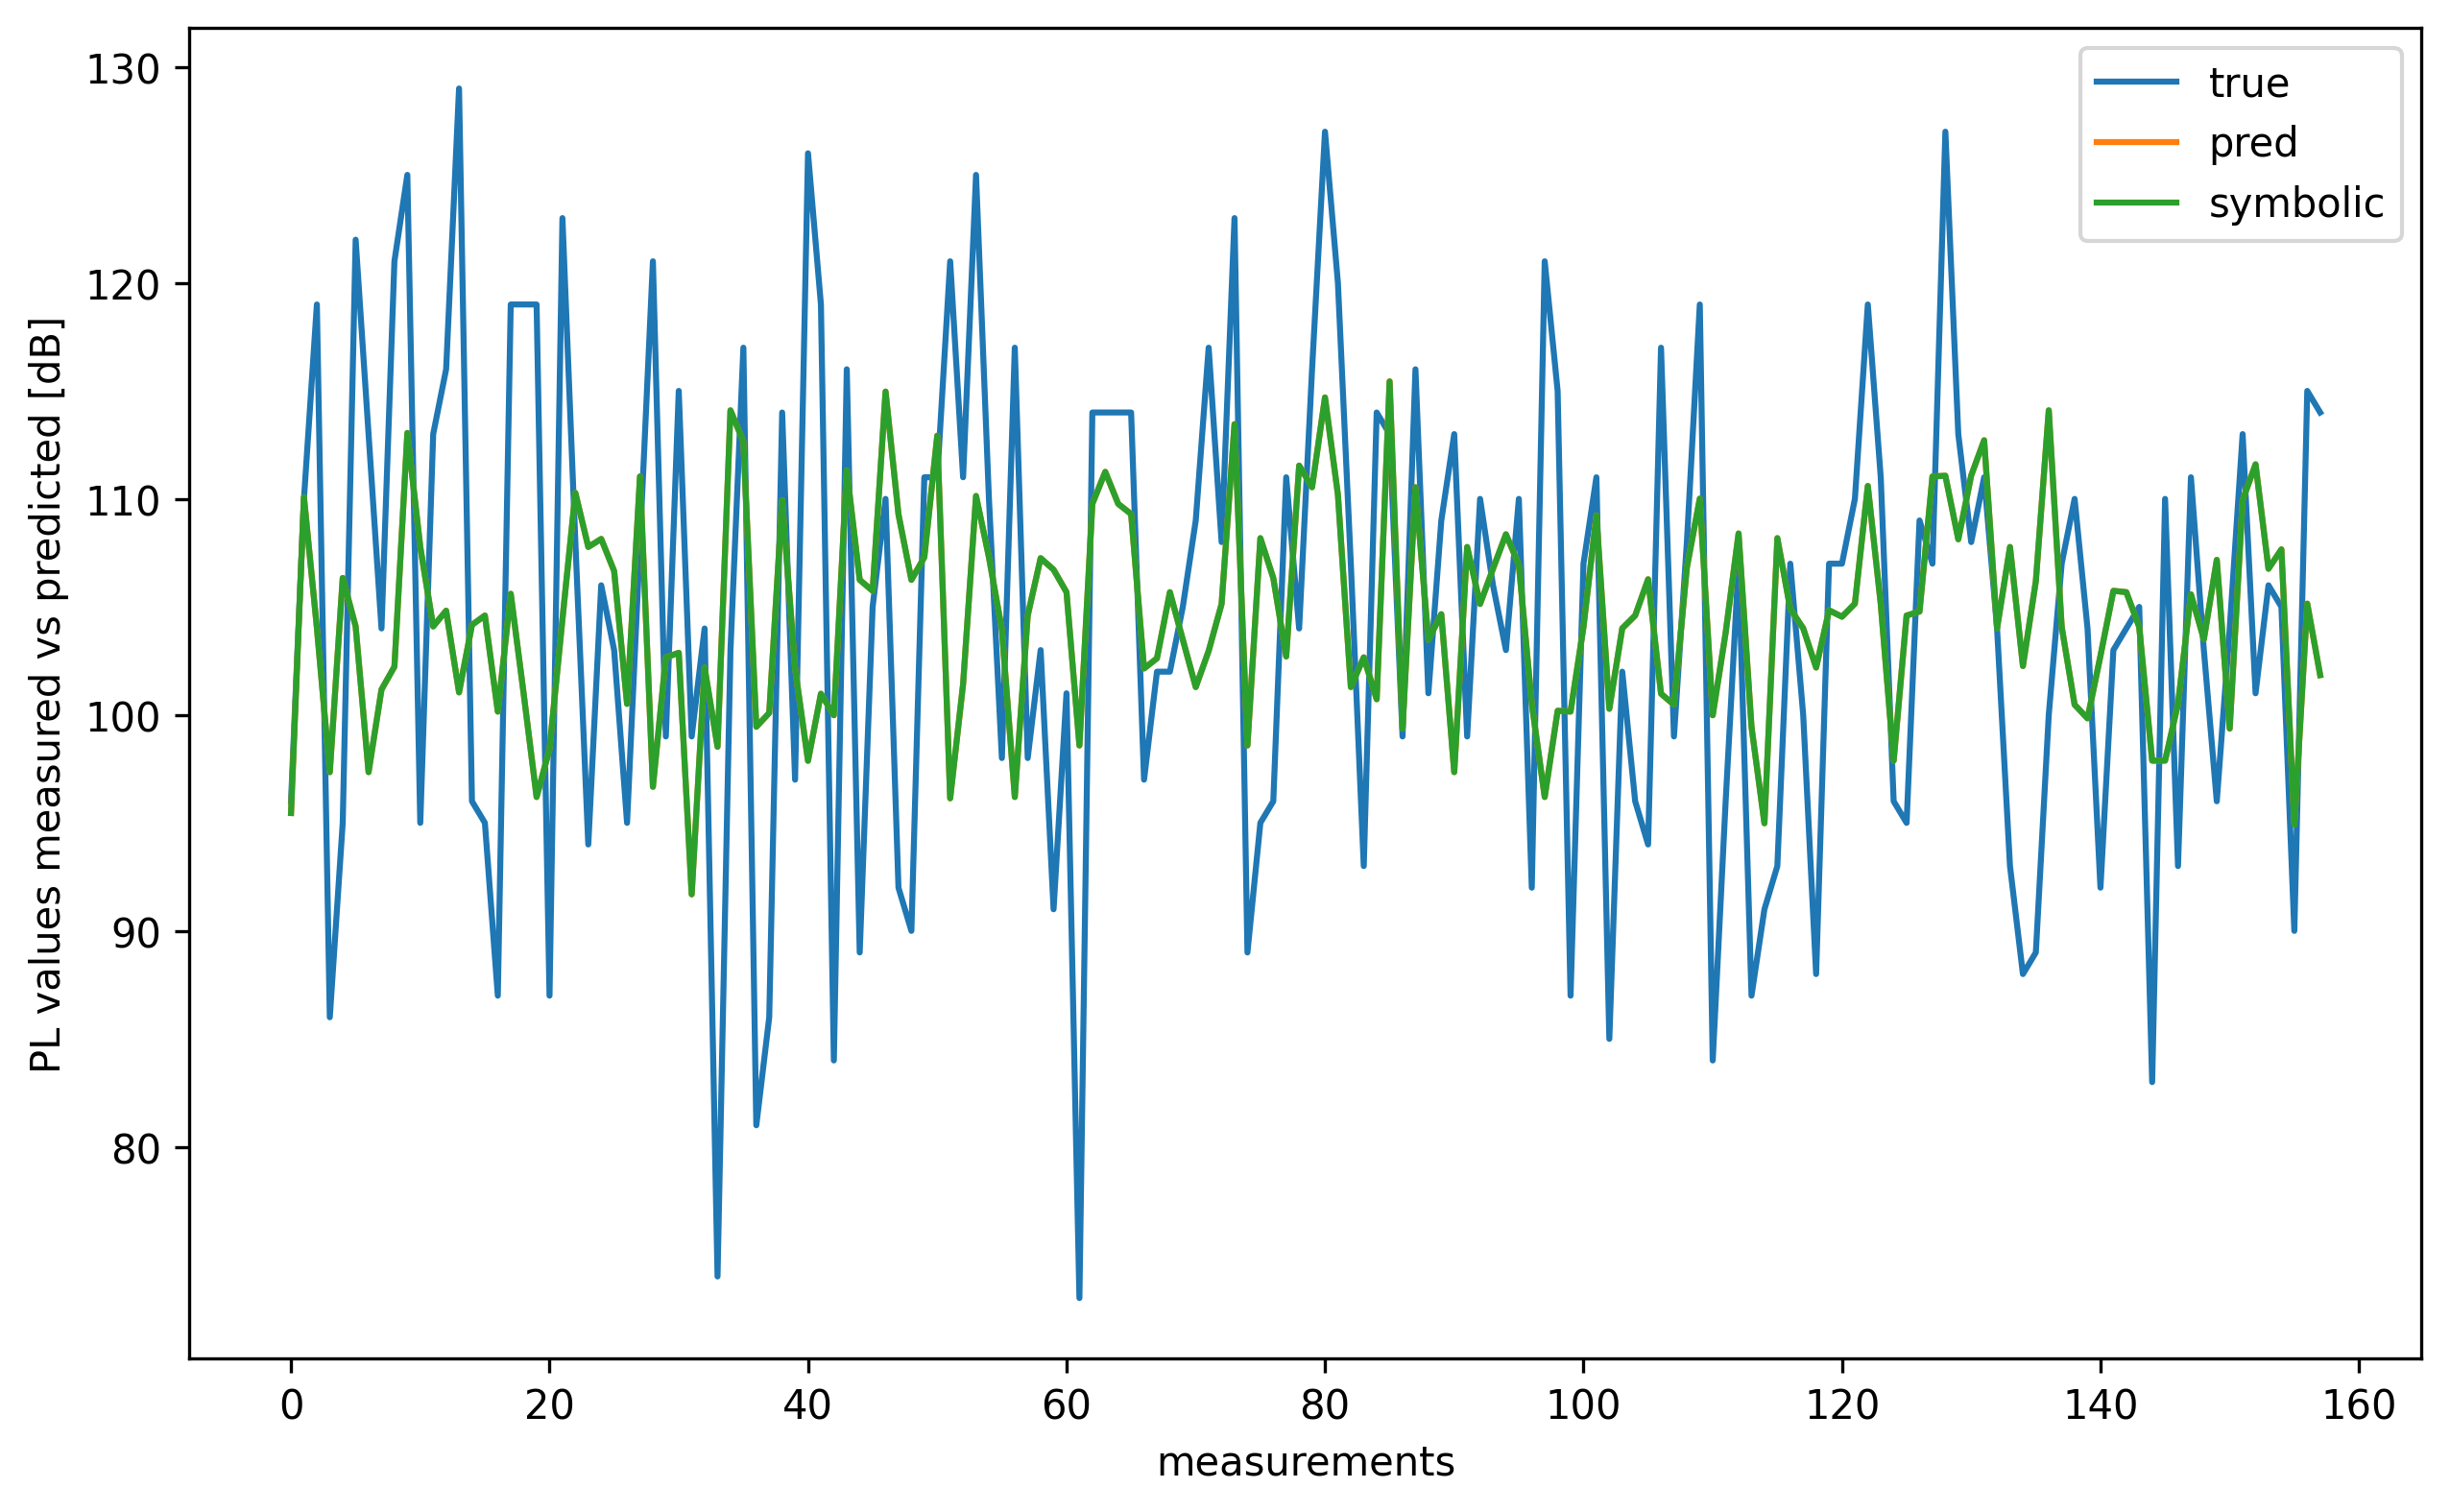

In [3]:

f = lambda x: 0.137 * x[:, 1] - 4.72 * np.log10(0.541 * x[:, 0] + 0.899) - 12.684 * np.log10(1.2 * x[:, 0] + 8.597) - 0.164 * np.sin(6.236 * x[:, 2] - 4.644) + 0.227 * np.sin(9.316 * x[:, 2] - 4.6) + 103.824
eval_kan(model, f, dataset)

checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.02


| train_loss: 9.47e+00 | test_loss: 1.07e+01 | reg: 9.22e+00 | : 100%|█| 50/50 [00:02<00:00, 18.06it


saving model version 0.1
MAE: 8.5820
MSE: 114.5668
MAPE: 8.4202
R²: 0.1318
RMSE: 10.7036
[np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.002


| train_loss: 9.46e+00 | test_loss: 1.06e+01 | reg: 1.12e+01 | : 100%|█| 50/50 [00:03<00:00, 16.00it


saving model version 0.1
MAE: 8.5209
MSE: 113.2164
MAPE: 8.3721
R²: 0.1420
RMSE: 10.6403
[np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.0002


| train_loss: 9.68e+00 | test_loss: 1.10e+01 | reg: 1.14e+01 | : 100%|█| 50/50 [00:02<00:00, 22.46it


saving model version 0.1
MAE: 8.7824
MSE: 119.9763
MAPE: 8.6026
R²: 0.0908
RMSE: 10.9534
[np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 2e-05


| train_loss: 9.44e+00 | test_loss: 1.07e+01 | reg: 1.20e+01 | : 100%|█| 50/50 [00:02<00:00, 17.62it


saving model version 0.1
MAE: 8.4599
MSE: 113.8230
MAPE: 8.2926
R²: 0.1374
RMSE: 10.6688
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.02


| train_loss: 9.47e+00 | test_loss: 1.07e+01 | reg: 9.23e+00 | : 100%|█| 100/100 [00:04<00:00, 24.00


saving model version 0.1
MAE: 8.5821
MSE: 114.5716
MAPE: 8.4203
R²: 0.1317
RMSE: 10.7038
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.002


| train_loss: 9.46e+00 | test_loss: 1.06e+01 | reg: 1.12e+01 | : 100%|█| 100/100 [00:04<00:00, 21.17


saving model version 0.1
MAE: 8.5220
MSE: 113.2347
MAPE: 8.3732
R²: 0.1418
RMSE: 10.6412
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.0002


| train_loss: 9.55e+00 | test_loss: 1.09e+01 | reg: 1.32e+01 | : 100%|█| 100/100 [00:03<00:00, 25.30


saving model version 0.1
MAE: 8.5953
MSE: 118.5518
MAPE: 8.4215
R²: 0.1016
RMSE: 10.8881
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 2e-05


| train_loss: 9.44e+00 | test_loss: 1.07e+01 | reg: 1.20e+01 | : 100%|█| 100/100 [00:04<00:00, 22.74


saving model version 0.1
MAE: 8.4594
MSE: 113.8473
MAPE: 8.2925
R²: 0.1372
RMSE: 10.6699
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.02


| train_loss: 9.47e+00 | test_loss: 1.07e+01 | reg: 9.23e+00 | : 100%|█| 200/200 [00:07<00:00, 28.42


saving model version 0.1
MAE: 8.5821
MSE: 114.5716
MAPE: 8.4203
R²: 0.1317
RMSE: 10.7038
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.002


| train_loss: 9.46e+00 | test_loss: 1.06e+01 | reg: 1.12e+01 | : 100%|█| 200/200 [00:07<00:00, 25.36


saving model version 0.1
MAE: 8.5220
MSE: 113.2347
MAPE: 8.3732
R²: 0.1418
RMSE: 10.6412
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.0002


| train_loss: 9.55e+00 | test_loss: 1.09e+01 | reg: 1.32e+01 | : 100%|█| 200/200 [00:07<00:00, 28.37


saving model version 0.1
MAE: 8.5953
MSE: 118.5518
MAPE: 8.4215
R²: 0.1016
RMSE: 10.8881
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 2e-05


| train_loss: 9.44e+00 | test_loss: 1.07e+01 | reg: 1.20e+01 | : 100%|█| 200/200 [00:07<00:00, 28.23


saving model version 0.1
MAE: 8.4594
MSE: 113.8473
MAPE: 8.2925
R²: 0.1372
RMSE: 10.6699
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.02


| train_loss: 9.47e+00 | test_loss: 1.07e+01 | reg: 9.23e+00 | : 100%|█| 300/300 [00:09<00:00, 30.28


saving model version 0.1
MAE: 8.5821
MSE: 114.5716
MAPE: 8.4203
R²: 0.1317
RMSE: 10.7038
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.002


| train_loss: 9.46e+00 | test_loss: 1.06e+01 | reg: 1.12e+01 | : 100%|█| 300/300 [00:10<00:00, 27.27


saving model version 0.1
MAE: 8.5220
MSE: 113.2347
MAPE: 8.3732
R²: 0.1418
RMSE: 10.6412
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.0002


| train_loss: 9.55e+00 | test_loss: 1.09e+01 | reg: 1.32e+01 | : 100%|█| 300/300 [00:09<00:00, 30.76


saving model version 0.1
MAE: 8.5953
MSE: 118.5518
MAPE: 8.4215
R²: 0.1016
RMSE: 10.8881
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 2e-05


| train_loss: 9.44e+00 | test_loss: 1.07e+01 | reg: 1.20e+01 | : 100%|█| 300/300 [00:09<00:00, 30.85


saving model version 0.1
MAE: 8.4594
MSE: 113.8473
MAPE: 8.2925
R²: 0.1372
RMSE: 10.6699
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 0.02


| train_loss: 9.25e+00 | test_loss: 1.06e+01 | reg: 2.32e+01 | : 100%|█| 50/50 [00:03<00:00, 14.66it


saving model version 0.1
MAE: 8.4628
MSE: 113.0426
MAPE: 8.2815
R²: 0.1433
RMSE: 10.6322
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 0.002


| train_loss: 9.42e+00 | test_loss: 1.04e+01 | reg: 1.87e+01 | : 100%|█| 50/50 [00:02<00:00, 16.95it


saving model version 0.1
MAE: 8.2992
MSE: 107.5127
MAPE: 8.0990
R²: 0.1852
RMSE: 10.3688
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 0.0002


| train_loss: 9.47e+00 | test_loss: 1.04e+01 | reg: 2.15e+01 | : 100%|█| 50/50 [00:02<00:00, 17.35it


saving model version 0.1
MAE: 8.2603
MSE: 107.8935
MAPE: 8.0557
R²: 0.1823
RMSE: 10.3872
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 2e-05


| train_loss: 9.40e+00 | test_loss: 1.06e+01 | reg: 1.39e+01 | : 100%|█| 50/50 [00:02<00:00, 19.07it


saving model version 0.1
MAE: 8.6287
MSE: 112.7791
MAPE: 8.3705
R²: 0.1453
RMSE: 10.6197
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.02


| train_loss: 9.25e+00 | test_loss: 1.06e+01 | reg: 2.32e+01 | : 100%|█| 100/100 [00:04<00:00, 20.95


saving model version 0.1
MAE: 8.4628
MSE: 113.0427
MAPE: 8.2815
R²: 0.1433
RMSE: 10.6322
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.002


| train_loss: 9.42e+00 | test_loss: 1.04e+01 | reg: 1.87e+01 | : 100%|█| 100/100 [00:04<00:00, 24.88


saving model version 0.1
MAE: 8.2992
MSE: 107.5127
MAPE: 8.0990
R²: 0.1852
RMSE: 10.3688
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.0002


| train_loss: 9.47e+00 | test_loss: 1.04e+01 | reg: 2.15e+01 | : 100%|█| 100/100 [00:03<00:00, 25.58


saving model version 0.1
MAE: 8.2603
MSE: 107.8935
MAPE: 8.0557
R²: 0.1823
RMSE: 10.3872
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 2e-05


| train_loss: 9.40e+00 | test_loss: 1.06e+01 | reg: 1.39e+01 | : 100%|█| 100/100 [00:04<00:00, 23.71


saving model version 0.1
MAE: 8.6287
MSE: 112.7791
MAPE: 8.3705
R²: 0.1453
RMSE: 10.6197
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.02


| train_loss: 9.25e+00 | test_loss: 1.06e+01 | reg: 2.32e+01 | : 100%|█| 200/200 [00:07<00:00, 25.39


saving model version 0.1
MAE: 8.4628
MSE: 113.0427
MAPE: 8.2815
R²: 0.1433
RMSE: 10.6322
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.002


| train_loss: 9.42e+00 | test_loss: 1.04e+01 | reg: 1.87e+01 | : 100%|█| 200/200 [00:06<00:00, 29.83


saving model version 0.1
MAE: 8.3045
MSE: 107.4997
MAPE: 8.1049
R²: 0.1853
RMSE: 10.3682
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.0002


| train_loss: 9.47e+00 | test_loss: 1.04e+01 | reg: 2.15e+01 | : 100%|█| 200/200 [00:07<00:00, 27.43


saving model version 0.1
MAE: 8.2603
MSE: 107.8914
MAPE: 8.0557
R²: 0.1823
RMSE: 10.3871
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 2e-05


| train_loss: 9.40e+00 | test_loss: 1.06e+01 | reg: 1.39e+01 | : 100%|█| 200/200 [00:07<00:00, 26.71


saving model version 0.1
MAE: 8.6287
MSE: 112.7791
MAPE: 8.3705
R²: 0.1453
RMSE: 10.6197
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.02


| train_loss: 9.25e+00 | test_loss: 1.06e+01 | reg: 2.32e+01 | : 100%|█| 300/300 [00:11<00:00, 26.62


saving model version 0.1
MAE: 8.4628
MSE: 113.0427
MAPE: 8.2815
R²: 0.1433
RMSE: 10.6322
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.002


| train_loss: 9.42e+00 | test_loss: 1.04e+01 | reg: 1.87e+01 | : 100%|█| 300/300 [00:09<00:00, 30.38


saving model version 0.1
MAE: 8.3045
MSE: 107.4997
MAPE: 8.1049
R²: 0.1853
RMSE: 10.3682
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.0002


| train_loss: 9.47e+00 | test_loss: 1.04e+01 | reg: 2.15e+01 | : 100%|█| 300/300 [00:11<00:00, 26.71


saving model version 0.1
MAE: 8.2603
MSE: 107.8914
MAPE: 8.0557
R²: 0.1823
RMSE: 10.3871
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 2e-05


| train_loss: 9.40e+00 | test_loss: 1.06e+01 | reg: 1.39e+01 | : 100%|█| 300/300 [00:11<00:00, 26.89


saving model version 0.1
MAE: 8.6287
MSE: 112.7791
MAPE: 8.3705
R²: 0.1453
RMSE: 10.6197
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 0.02


| train_loss: 8.92e+00 | test_loss: 1.01e+01 | reg: 1.66e+01 | : 100%|█| 50/50 [00:03<00:00, 12.69it


saving model version 0.1
MAE: 8.0299
MSE: 101.3538
MAPE: 7.8326
R²: 0.2319
RMSE: 10.0675
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 0.002


| train_loss: 9.33e+00 | test_loss: 1.07e+01 | reg: 1.85e+01 | : 100%|█| 50/50 [00:02<00:00, 19.60it


saving model version 0.1
MAE: 8.3245
MSE: 114.4151
MAPE: 8.1063
R²: 0.1329
RMSE: 10.6965
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 0.0002


| train_loss: 9.47e+00 | test_loss: 1.09e+01 | reg: 3.33e+01 | : 100%|█| 50/50 [00:02<00:00, 16.80it


saving model version 0.1
MAE: 8.7501
MSE: 118.2762
MAPE: 8.4855
R²: 0.1036
RMSE: 10.8755
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 2e-05


| train_loss: 9.34e+00 | test_loss: 1.07e+01 | reg: 1.22e+01 | : 100%|█| 50/50 [00:03<00:00, 14.47it


saving model version 0.1
MAE: 8.6031
MSE: 113.7867
MAPE: 8.4301
R²: 0.1377
RMSE: 10.6671
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.02


| train_loss: 8.92e+00 | test_loss: 1.01e+01 | reg: 1.66e+01 | : 100%|█| 100/100 [00:05<00:00, 19.71


saving model version 0.1
MAE: 8.0299
MSE: 101.3538
MAPE: 7.8326
R²: 0.2319
RMSE: 10.0675
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.002


| train_loss: 9.33e+00 | test_loss: 1.07e+01 | reg: 1.85e+01 | : 100%|█| 100/100 [00:04<00:00, 24.30


saving model version 0.1
MAE: 8.3245
MSE: 114.4151
MAPE: 8.1063
R²: 0.1329
RMSE: 10.6965
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.0002


| train_loss: 9.47e+00 | test_loss: 1.09e+01 | reg: 3.33e+01 | : 100%|█| 100/100 [00:04<00:00, 21.21


saving model version 0.1
MAE: 8.7501
MSE: 118.2762
MAPE: 8.4855
R²: 0.1036
RMSE: 10.8755
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 2e-05


| train_loss: 9.34e+00 | test_loss: 1.07e+01 | reg: 1.22e+01 | : 100%|█| 100/100 [00:05<00:00, 19.01


saving model version 0.1
MAE: 8.6028
MSE: 113.7837
MAPE: 8.4300
R²: 0.1377
RMSE: 10.6669
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.02


| train_loss: 8.92e+00 | test_loss: 1.01e+01 | reg: 1.66e+01 | : 100%|█| 200/200 [00:07<00:00, 25.75


saving model version 0.1
MAE: 8.0299
MSE: 101.3538
MAPE: 7.8326
R²: 0.2319
RMSE: 10.0675
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.002


| train_loss: 9.33e+00 | test_loss: 1.07e+01 | reg: 1.85e+01 | : 100%|█| 200/200 [00:07<00:00, 26.04


saving model version 0.1
MAE: 8.3245
MSE: 114.4151
MAPE: 8.1063
R²: 0.1329
RMSE: 10.6965
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.0002


| train_loss: 9.47e+00 | test_loss: 1.09e+01 | reg: 3.33e+01 | : 100%|█| 200/200 [00:07<00:00, 25.18


saving model version 0.1
MAE: 8.7501
MSE: 118.2762
MAPE: 8.4855
R²: 0.1036
RMSE: 10.8755
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 2e-0

| train_loss: 9.34e+00 | test_loss: 1.07e+01 | reg: 1.22e+01 | : 100%|█| 200/200 [00:07<00:00, 25.24


saving model version 0.1
MAE: 8.6028
MSE: 113.7837
MAPE: 8.4300
R²: 0.1377
RMSE: 10.6669
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 

| train_loss: 8.92e+00 | test_loss: 1.01e+01 | reg: 1.66e+01 | : 100%|█| 300/300 [00:10<00:00, 29.21


saving model version 0.1
MAE: 8.0299
MSE: 101.3538
MAPE: 7.8326
R²: 0.2319
RMSE: 10.0675
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model versi

| train_loss: 9.33e+00 | test_loss: 1.07e+01 | reg: 1.85e+01 | : 100%|█| 300/300 [00:11<00:00, 27.14


saving model version 0.1
MAE: 8.3245
MSE: 114.4151
MAPE: 8.1063
R²: 0.1329
RMSE: 10.6965
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model

| train_loss: 9.47e+00 | test_loss: 1.09e+01 | reg: 3.33e+01 | : 100%|█| 300/300 [00:11<00:00, 26.94


saving model version 0.1
MAE: 8.7501
MSE: 118.2762
MAPE: 8.4855
R²: 0.1036
RMSE: 10.8755
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint direct

| train_loss: 9.34e+00 | test_loss: 1.07e+01 | reg: 1.22e+01 | : 100%|█| 300/300 [00:10<00:00, 28.56


saving model version 0.1
MAE: 8.6028
MSE: 113.7837
MAPE: 8.4300
R²: 0.1377
RMSE: 10.6669
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)

| train_loss: 8.28e+00 | test_loss: 9.34e+00 | reg: 9.97e+00 | : 100%|█| 50/50 [00:19<00:00,  2.63it


saving model version 0.1
MAE: 7.4060
MSE: 87.1455
MAPE: 7.3156
R²: 0.3396
RMSE: 9.3352
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.28e+00 | test_loss: 9.73e+00 | reg: 1.19e+01 | : 100%|█| 50/50 [00:19<00:00,  2.63it


saving model version 0.1
MAE: 7.8017
MSE: 94.6220
MAPE: 7.6675
R²: 0.2829
RMSE: 9.7274
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.28e+00 | test_loss: 9.06e+00 | reg: 1.03e+01 | : 100%|█| 50/50 [00:20<00:00,  2.42it


saving model version 0.1
MAE: 7.2930
MSE: 82.0546
MAPE: 7.0083
R²: 0.3781
RMSE: 9.0584
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.86e+00 | test_loss: 8.90e+00 | reg: 1.40e+01 | : 100%|█| 50/50 [00:18<00:00,  2.74it


saving model version 0.1
MAE: 6.9601
MSE: 79.2633
MAPE: 6.7923
R²: 0.3993
RMSE: 8.9030
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.12e+00 | test_loss: 9.20e+00 | reg: 1.01e+01 | : 100%|█| 100/100 [00:32<00:00,  3.09


saving model version 0.1
MAE: 7.2807
MSE: 84.7207
MAPE: 7.1611
R²: 0.3579
RMSE: 9.2044
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.75e+00 | test_loss: 9.02e+00 | reg: 1.21e+01 | : 100%|█| 100/100 [00:36<00:00,  2.74


saving model version 0.1
MAE: 6.8419
MSE: 81.3846
MAPE: 6.7220
R²: 0.3832
RMSE: 9.0213
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.93e+00 | test_loss: 8.61e+00 | reg: 9.66e+00 | : 100%|█| 100/100 [00:27<00:00,  3.65


saving model version 0.1
MAE: 6.7872
MSE: 74.1594
MAPE: 6.5585
R²: 0.4380
RMSE: 8.6116
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.65e+00 | test_loss: 8.81e+00 | reg: 1.44e+01 | : 100%|█| 100/100 [00:27<00:00,  3.62


saving model version 0.1
MAE: 6.8624
MSE: 77.5706
MAPE: 6.7101
R²: 0.4121
RMSE: 8.8074
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.99e+00 | test_loss: 8.98e+00 | reg: 1.11e+01 | : 100%|█| 200/200 [01:02<00:00,  3.18


saving model version 0.1
MAE: 7.0485
MSE: 80.7214
MAPE: 6.9451
R²: 0.3882
RMSE: 8.9845
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.75e+00 | test_loss: 9.03e+00 | reg: 1.21e+01 | : 100%|█| 200/200 [00:50<00:00,  3.96


saving model version 0.1
MAE: 6.8623
MSE: 81.5662
MAPE: 6.7396
R²: 0.3818
RMSE: 9.0314
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.93e+00 | test_loss: 8.61e+00 | reg: 9.66e+00 | : 100%|█| 200/200 [00:42<00:00,  4.74


saving model version 0.1
MAE: 6.7872
MSE: 74.1594
MAPE: 6.5585
R²: 0.4380
RMSE: 8.6116
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.65e+00 | test_loss: 8.81e+00 | reg: 1.44e+01 | : 100%|█| 200/200 [00:39<00:00,  5.10


saving model version 0.1
MAE: 6.8624
MSE: 77.5706
MAPE: 6.7101
R²: 0.4121
RMSE: 8.8074
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.94e+00 | test_loss: 8.93e+00 | reg: 1.05e+01 | : 100%|█| 300/300 [01:15<00:00,  3.96


saving model version 0.1
MAE: 7.0144
MSE: 79.7122
MAPE: 6.8959
R²: 0.3959
RMSE: 8.9282
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.75e+00 | test_loss: 9.03e+00 | reg: 1.21e+01 | : 100%|█| 300/300 [01:06<00:00,  4.50


saving model version 0.1
MAE: 6.8623
MSE: 81.5662
MAPE: 6.7396
R²: 0.3818
RMSE: 9.0314
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.93e+00 | test_loss: 8.61e+00 | reg: 9.66e+00 | : 100%|█| 300/300 [16:28<00:00,  3.30


saving model version 0.1
MAE: 6.7872
MSE: 74.1594
MAPE: 6.5585
R²: 0.4380
RMSE: 8.6116
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.65e+00 | test_loss: 8.81e+00 | reg: 1.44e+01 | : 100%|█| 300/300 [02:28<00:00,  2.02


saving model version 0.1
MAE: 6.8624
MSE: 77.5706
MAPE: 6.7101
R²: 0.4121
RMSE: 8.8074
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.31e+00 | test_loss: 9.35e+00 | reg: 1.26e+01 | : 100%|█| 50/50 [00:27<00:00,  1.82it


saving model version 0.1
MAE: 7.4152
MSE: 87.4889
MAPE: 7.2239
R²: 0.3370
RMSE: 9.3535
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.25e+00 | test_loss: 9.75e+00 | reg: 1.41e+01 | : 100%|█| 50/50 [00:23<00:00,  2.14it


saving model version 0.1
MAE: 7.6984
MSE: 95.1550
MAPE: 7.5529
R²: 0.2789
RMSE: 9.7547
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.92e+00 | test_loss: 8.62e+00 | reg: 1.42e+01 | : 100%|█| 50/50 [00:20<00:00,  2.47it


saving model version 0.1
MAE: 6.6922
MSE: 74.3348
MAPE: 6.5185
R²: 0.4367
RMSE: 8.6218
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.12e+00 | test_loss: 8.87e+00 | reg: 1.38e+01 | : 100%|█| 50/50 [00:21<00:00,  2.32it


saving model version 0.1
MAE: 7.0146
MSE: 78.6921
MAPE: 6.8113
R²: 0.4036
RMSE: 8.8709
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.04e+00 | test_loss: 9.08e+00 | reg: 1.38e+01 | : 100%|█| 100/100 [00:36<00:00,  2.77


saving model version 0.1
MAE: 7.1996
MSE: 82.4141
MAPE: 7.0299
R²: 0.3754
RMSE: 9.0782
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.89e+00 | test_loss: 9.41e+00 | reg: 1.42e+01 | : 100%|█| 100/100 [00:39<00:00,  2.54


saving model version 0.1
MAE: 7.2216
MSE: 88.6233
MAPE: 7.0780
R²: 0.3284
RMSE: 9.4140
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.79e+00 | test_loss: 8.62e+00 | reg: 1.49e+01 | : 100%|█| 100/100 [00:35<00:00,  2.84


saving model version 0.1
MAE: 6.6362
MSE: 74.2201
MAPE: 6.4917
R²: 0.4375
RMSE: 8.6151
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.83e+00 | test_loss: 8.73e+00 | reg: 1.40e+01 | : 100%|█| 100/100 [00:38<00:00,  2.62


saving model version 0.1
MAE: 6.7071
MSE: 76.2803
MAPE: 6.5295
R²: 0.4219
RMSE: 8.7339
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.85e+00 | test_loss: 8.84e+00 | reg: 1.45e+01 | : 100%|█| 200/200 [00:51<00:00,  3.88


saving model version 0.1
MAE: 6.8947
MSE: 78.1728
MAPE: 6.7304
R²: 0.4076
RMSE: 8.8415
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.50e+00 | test_loss: 8.62e+00 | reg: 1.54e+01 | : 100%|█| 200/200 [01:15<00:00,  2.66


saving model version 0.1
MAE: 6.4616
MSE: 74.2245
MAPE: 6.3213
R²: 0.4375
RMSE: 8.6154
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.51e+00 | test_loss: 8.40e+00 | reg: 1.43e+01 | : 100%|█| 200/200 [01:09<00:00,  2.89


saving model version 0.1
MAE: 6.2251
MSE: 70.4979
MAPE: 6.0860
R²: 0.4657
RMSE: 8.3963
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.54e+00 | test_loss: 8.51e+00 | reg: 1.43e+01 | : 100%|█| 200/200 [01:09<00:00,  2.86


saving model version 0.1
MAE: 6.3472
MSE: 72.3731
MAPE: 6.1984
R²: 0.4515
RMSE: 8.5072
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.83e+00 | test_loss: 8.76e+00 | reg: 1.44e+01 | : 100%|█| 300/300 [01:16<00:00,  3.90


saving model version 0.1
MAE: 6.8214
MSE: 76.6593
MAPE: 6.6629
R²: 0.4190
RMSE: 8.7555
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.50e+00 | test_loss: 8.62e+00 | reg: 1.54e+01 | : 100%|█| 300/300 [01:32<00:00,  3.24


saving model version 0.1
MAE: 6.4616
MSE: 74.2247
MAPE: 6.3213
R²: 0.4375
RMSE: 8.6154
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.51e+00 | test_loss: 8.40e+00 | reg: 1.43e+01 | : 100%|█| 300/300 [01:24<00:00,  3.54


saving model version 0.1
MAE: 6.2251
MSE: 70.4979
MAPE: 6.0860
R²: 0.4657
RMSE: 8.3963
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.54e+00 | test_loss: 8.51e+00 | reg: 1.43e+01 | : 100%|█| 300/300 [10:19<00:00,  2.06


saving model version 0.1
MAE: 6.3472
MSE: 72.3731
MAPE: 6.1984
R²: 0.4515
RMSE: 8.5072
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.34e+00 | test_loss: 9.39e+00 | reg: 1.74e+01 | : 100%|█| 50/50 [04:17<00:00,  5.14s/


saving model version 0.1
MAE: 7.6291
MSE: 88.1294
MAPE: 7.4087
R²: 0.3321
RMSE: 9.3877
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.90e+00 | test_loss: 9.48e+00 | reg: 1.26e+01 | : 100%|█| 50/50 [00:16<00:00,  3.12it


saving model version 0.1
MAE: 7.1080
MSE: 89.7878
MAPE: 6.9670
R²: 0.3195
RMSE: 9.4756
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.86e+00 | test_loss: 9.11e+00 | reg: 1.80e+01 | : 100%|█| 50/50 [00:23<00:00,  2.12it


saving model version 0.1
MAE: 6.7296
MSE: 82.9667
MAPE: 6.6046
R²: 0.3712
RMSE: 9.1086
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.99e+00 | test_loss: 9.25e+00 | reg: 1.24e+01 | : 100%|█| 50/50 [01:02<00:00,  1.25s/


saving model version 0.1
MAE: 6.9233
MSE: 85.6047
MAPE: 6.8153
R²: 0.3512
RMSE: 9.2523
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.34e+00 | test_loss: 9.39e+00 | reg: 1.74e+01 | : 100%|█| 100/100 [00:24<00:00,  4.08


saving model version 0.1
MAE: 7.6285
MSE: 88.1158
MAPE: 7.4082
R²: 0.3322
RMSE: 9.3870
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.90e+00 | test_loss: 9.48e+00 | reg: 1.26e+01 | : 100%|█| 100/100 [07:32<00:00,  4.53


saving model version 0.1
MAE: 7.1080
MSE: 89.7878
MAPE: 6.9670
R²: 0.3195
RMSE: 9.4756
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.33e+00 | test_loss: 9.05e+00 | reg: 1.51e+01 | : 100%|█| 100/100 [03:11<00:00,  1.91


saving model version 0.1
MAE: 6.5184
MSE: 81.9176
MAPE: 6.3910
R²: 0.3792
RMSE: 9.0508
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.99e+00 | test_loss: 9.25e+00 | reg: 1.24e+01 | : 100%|█| 100/100 [00:26<00:00,  3.75


saving model version 0.1
MAE: 6.9233
MSE: 85.6049
MAPE: 6.8153
R²: 0.3512
RMSE: 9.2523
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.34e+00 | test_loss: 9.39e+00 | reg: 1.74e+01 | : 100%|█| 200/200 [00:35<00:00,  5.56


saving model version 0.1
MAE: 7.6285
MSE: 88.1158
MAPE: 7.4082
R²: 0.3322
RMSE: 9.3870
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.90e+00 | test_loss: 9.48e+00 | reg: 1.26e+01 | : 100%|█| 200/200 [00:42<00:00,  4.68


saving model version 0.1
MAE: 7.1080
MSE: 89.7886
MAPE: 6.9669
R²: 0.3195
RMSE: 9.4757
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.33e+00 | test_loss: 9.05e+00 | reg: 1.51e+01 | : 100%|█| 200/200 [00:55<00:00,  3.57


saving model version 0.1
MAE: 6.5184
MSE: 81.9231
MAPE: 6.3909
R²: 0.3791
RMSE: 9.0511
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.99e+00 | test_loss: 9.25e+00 | reg: 1.24e+01 | : 100%|█| 200/200 [00:39<00:00,  5.04


saving model version 0.1
MAE: 6.9233
MSE: 85.6049
MAPE: 6.8153
R²: 0.3512
RMSE: 9.2523
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.34e+00 | test_loss: 9.39e+00 | reg: 1.74e+01 | : 100%|█| 300/300 [00:47<00:00,  6.27


saving model version 0.1
MAE: 7.6285
MSE: 88.1158
MAPE: 7.4082
R²: 0.3322
RMSE: 9.3870
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.90e+00 | test_loss: 9.48e+00 | reg: 1.26e+01 | : 100%|█| 300/300 [00:55<00:00,  5.44


saving model version 0.1
MAE: 7.1080
MSE: 89.7886
MAPE: 6.9669
R²: 0.3195
RMSE: 9.4757
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.33e+00 | test_loss: 9.05e+00 | reg: 1.51e+01 | : 100%|█| 300/300 [01:11<00:00,  4.19


saving model version 0.1
MAE: 6.5184
MSE: 81.9231
MAPE: 6.3909
R²: 0.3791
RMSE: 9.0511
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.99e+00 | test_loss: 9.25e+00 | reg: 1.24e+01 | : 100%|█| 300/300 [00:55<00:00,  5.41


saving model version 0.1
MAE: 6.9233
MSE: 85.6049
MAPE: 6.8153
R²: 0.3512
RMSE: 9.2523
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.06e+00 | test_loss: 9.43e+00 | reg: 1.27e+01 | : 100%|█| 50/50 [00:14<00:00,  3.49it


saving model version 0.1
MAE: 6.9804
MSE: 88.9760
MAPE: 6.8836
R²: 0.3257
RMSE: 9.4327
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.77e+00 | test_loss: 8.89e+00 | reg: 1.70e+01 | : 100%|█| 50/50 [00:15<00:00,  3.15it


saving model version 0.1
MAE: 6.7049
MSE: 78.9687
MAPE: 6.6029
R²: 0.4015
RMSE: 8.8864
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.57e+00 | test_loss: 8.97e+00 | reg: 2.39e+01 | : 100%|█| 50/50 [00:15<00:00,  3.25it


saving model version 0.1
MAE: 6.7998
MSE: 80.5254
MAPE: 6.6847
R²: 0.3897
RMSE: 8.9736
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.84e+00 | test_loss: 8.90e+00 | reg: 1.81e+01 | : 100%|█| 50/50 [00:14<00:00,  3.49it


saving model version 0.1
MAE: 6.7575
MSE: 79.2736
MAPE: 6.6354
R²: 0.3992
RMSE: 8.9036
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.43e+00 | test_loss: 8.49e+00 | reg: 1.60e+01 | : 100%|█| 100/100 [00:31<00:00,  3.18


saving model version 0.1
MAE: 6.1430
MSE: 72.1233
MAPE: 6.0369
R²: 0.4534
RMSE: 8.4925
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.70e+00 | test_loss: 8.71e+00 | reg: 1.69e+01 | : 100%|█| 100/100 [00:25<00:00,  3.85


saving model version 0.1
MAE: 6.6187
MSE: 75.9402
MAPE: 6.4996
R²: 0.4245
RMSE: 8.7144
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.30e+00 | test_loss: 8.27e+00 | reg: 2.48e+01 | : 100%|█| 100/100 [00:29<00:00,  3.41


saving model version 0.1
MAE: 6.2772
MSE: 68.4679
MAPE: 6.1067
R²: 0.4811
RMSE: 8.2745
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.62e+00 | test_loss: 9.01e+00 | reg: 1.92e+01 | : 100%|█| 100/100 [00:26<00:00,  3.82


saving model version 0.1
MAE: 6.7866
MSE: 81.2224
MAPE: 6.6822
R²: 0.3845
RMSE: 9.0123
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.43e+00 | test_loss: 8.49e+00 | reg: 1.60e+01 | : 100%|█| 200/200 [00:44<00:00,  4.53


saving model version 0.1
MAE: 6.1430
MSE: 72.1233
MAPE: 6.0369
R²: 0.4534
RMSE: 8.4925
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.70e+00 | test_loss: 8.71e+00 | reg: 1.69e+01 | : 100%|█| 200/200 [00:38<00:00,  5.17


saving model version 0.1
MAE: 6.6185
MSE: 75.9352
MAPE: 6.4989
R²: 0.4245
RMSE: 8.7141
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.30e+00 | test_loss: 8.27e+00 | reg: 2.48e+01 | : 100%|█| 200/200 [00:40<00:00,  4.90


saving model version 0.1
MAE: 6.2772
MSE: 68.4680
MAPE: 6.1067
R²: 0.4811
RMSE: 8.2745
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.60e+00 | test_loss: 9.03e+00 | reg: 1.97e+01 | : 100%|█| 200/200 [00:37<00:00,  5.27


saving model version 0.1
MAE: 6.7600
MSE: 81.4773
MAPE: 6.6503
R²: 0.3825
RMSE: 9.0265
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.43e+00 | test_loss: 8.49e+00 | reg: 1.60e+01 | : 100%|█| 300/300 [01:01<00:00,  4.90


saving model version 0.1
MAE: 6.1430
MSE: 72.1233
MAPE: 6.0369
R²: 0.4534
RMSE: 8.4925
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.70e+00 | test_loss: 8.71e+00 | reg: 1.69e+01 | : 100%|█| 300/300 [00:51<00:00,  5.86


saving model version 0.1
MAE: 6.6185
MSE: 75.9352
MAPE: 6.4989
R²: 0.4245
RMSE: 8.7141
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.30e+00 | test_loss: 8.27e+00 | reg: 2.48e+01 | : 100%|█| 300/300 [00:52<00:00,  5.68


saving model version 0.1
MAE: 6.2772
MSE: 68.4680
MAPE: 6.1067
R²: 0.4811
RMSE: 8.2745
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 7.60e+00 | test_loss: 9.03e+00 | reg: 1.97e+01 | : 100%|█| 300/300 [00:50<00:00,  5.88


saving model version 0.1
MAE: 6.7600
MSE: 81.4773
MAPE: 6.6503
R²: 0.3825
RMSE: 9.0265
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.27e+00 | test_loss: 9.37e+00 | reg: 1.64e+01 | : 100%|█| 50/50 [00:22<00:00,  2.22it


saving model version 0.1
MAE: 7.3543
MSE: 87.8596
MAPE: 7.1559
R²: 0.3342
RMSE: 9.3733
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 1.03e+01 | test_loss: 1.06e+01 | reg: 1.58e+01 | : 100%|█| 50/50 [00:16<00:00,  2.98it


saving model version 0.1
MAE: 8.2966
MSE: 113.0645
MAPE: 8.2540
R²: 0.1431
RMSE: 10.6332
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)

| train_loss: 9.43e+00 | test_loss: 1.07e+01 | reg: 1.23e+01 | : 100%|█| 50/50 [00:18<00:00,  2.65it


saving model version 0.1
MAE: 8.5912
MSE: 113.4971
MAPE: 8.4914
R²: 0.1399
RMSE: 10.6535
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)

| train_loss: 8.80e+00 | test_loss: 9.72e+00 | reg: 1.20e+01 | : 100%|█| 50/50 [00:25<00:00,  1.94it


saving model version 0.1
MAE: 7.5818
MSE: 94.5107
MAPE: 7.3391
R²: 0.2837
RMSE: 9.7217
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.27e+00 | test_loss: 9.35e+00 | reg: 1.63e+01 | : 100%|█| 100/100 [00:36<00:00,  2.77


saving model version 0.1
MAE: 7.3160
MSE: 87.4639
MAPE: 7.1177
R²: 0.3372
RMSE: 9.3522
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 1.03e+01 | test_loss: 1.06e+01 | reg: 1.58e+01 | : 100%|█| 100/100 [00:26<00:00,  3.84


saving model version 0.1
MAE: 8.2966
MSE: 113.0645
MAPE: 8.2540
R²: 0.1431
RMSE: 10.6332
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)

| train_loss: 9.43e+00 | test_loss: 1.07e+01 | reg: 1.23e+01 | : 100%|█| 100/100 [03:17<00:00,  1.97


saving model version 0.1
MAE: 8.5912
MSE: 113.4971
MAPE: 8.4914
R²: 0.1399
RMSE: 10.6535
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)

| train_loss: 8.73e+00 | test_loss: 9.78e+00 | reg: 1.18e+01 | : 100%|█| 100/100 [00:52<00:00,  1.91


saving model version 0.1
MAE: 7.6076
MSE: 95.6311
MAPE: 7.3970
R²: 0.2753
RMSE: 9.7791
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.27e+00 | test_loss: 9.35e+00 | reg: 1.63e+01 | : 100%|█| 200/200 [00:44<00:00,  4.48


saving model version 0.1
MAE: 7.3152
MSE: 87.4768
MAPE: 7.1168
R²: 0.3371
RMSE: 9.3529
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 1.03e+01 | test_loss: 1.06e+01 | reg: 1.58e+01 | : 100%|█| 200/200 [03:54<00:00,  1.17


saving model version 0.1
MAE: 8.2966
MSE: 113.0645
MAPE: 8.2540
R²: 0.1431
RMSE: 10.6332
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)

| train_loss: 9.43e+00 | test_loss: 1.07e+01 | reg: 1.23e+01 | : 100%|█| 200/200 [02:35<00:00,  1.29


saving model version 0.1
MAE: 8.5912
MSE: 113.4971
MAPE: 8.4914
R²: 0.1399
RMSE: 10.6535
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)

| train_loss: 8.73e+00 | test_loss: 9.78e+00 | reg: 1.18e+01 | : 100%|█| 200/200 [12:47<00:00,  3.84


saving model version 0.1
MAE: 7.6076
MSE: 95.6311
MAPE: 7.3970
R²: 0.2753
RMSE: 9.7791
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 8.27e+00 | test_loss: 9.35e+00 | reg: 1.63e+01 | : 100%|█| 300/300 [01:12<00:00,  4.17


saving model version 0.1
MAE: 7.3152
MSE: 87.4768
MAPE: 7.1168
R²: 0.3371
RMSE: 9.3529
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 1.03e+01 | test_loss: 1.06e+01 | reg: 1.58e+01 | : 100%|█| 300/300 [00:51<00:00,  5.78


saving model version 0.1
MAE: 8.2966
MSE: 113.0645
MAPE: 8.2540
R²: 0.1431
RMSE: 10.6332
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)

| train_loss: 9.43e+00 | test_loss: 1.07e+01 | reg: 1.23e+01 | : 100%|█| 300/300 [00:58<00:00,  5.12


saving model version 0.1
MAE: 8.5912
MSE: 113.4971
MAPE: 8.4914
R²: 0.1399
RMSE: 10.6535
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)

| train_loss: 8.73e+00 | test_loss: 9.78e+00 | reg: 1.18e+01 | : 100%|█| 300/300 [01:23<00:00,  3.60


saving model version 0.1
MAE: 7.6076
MSE: 95.6311
MAPE: 7.3970
R²: 0.2753
RMSE: 9.7791
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

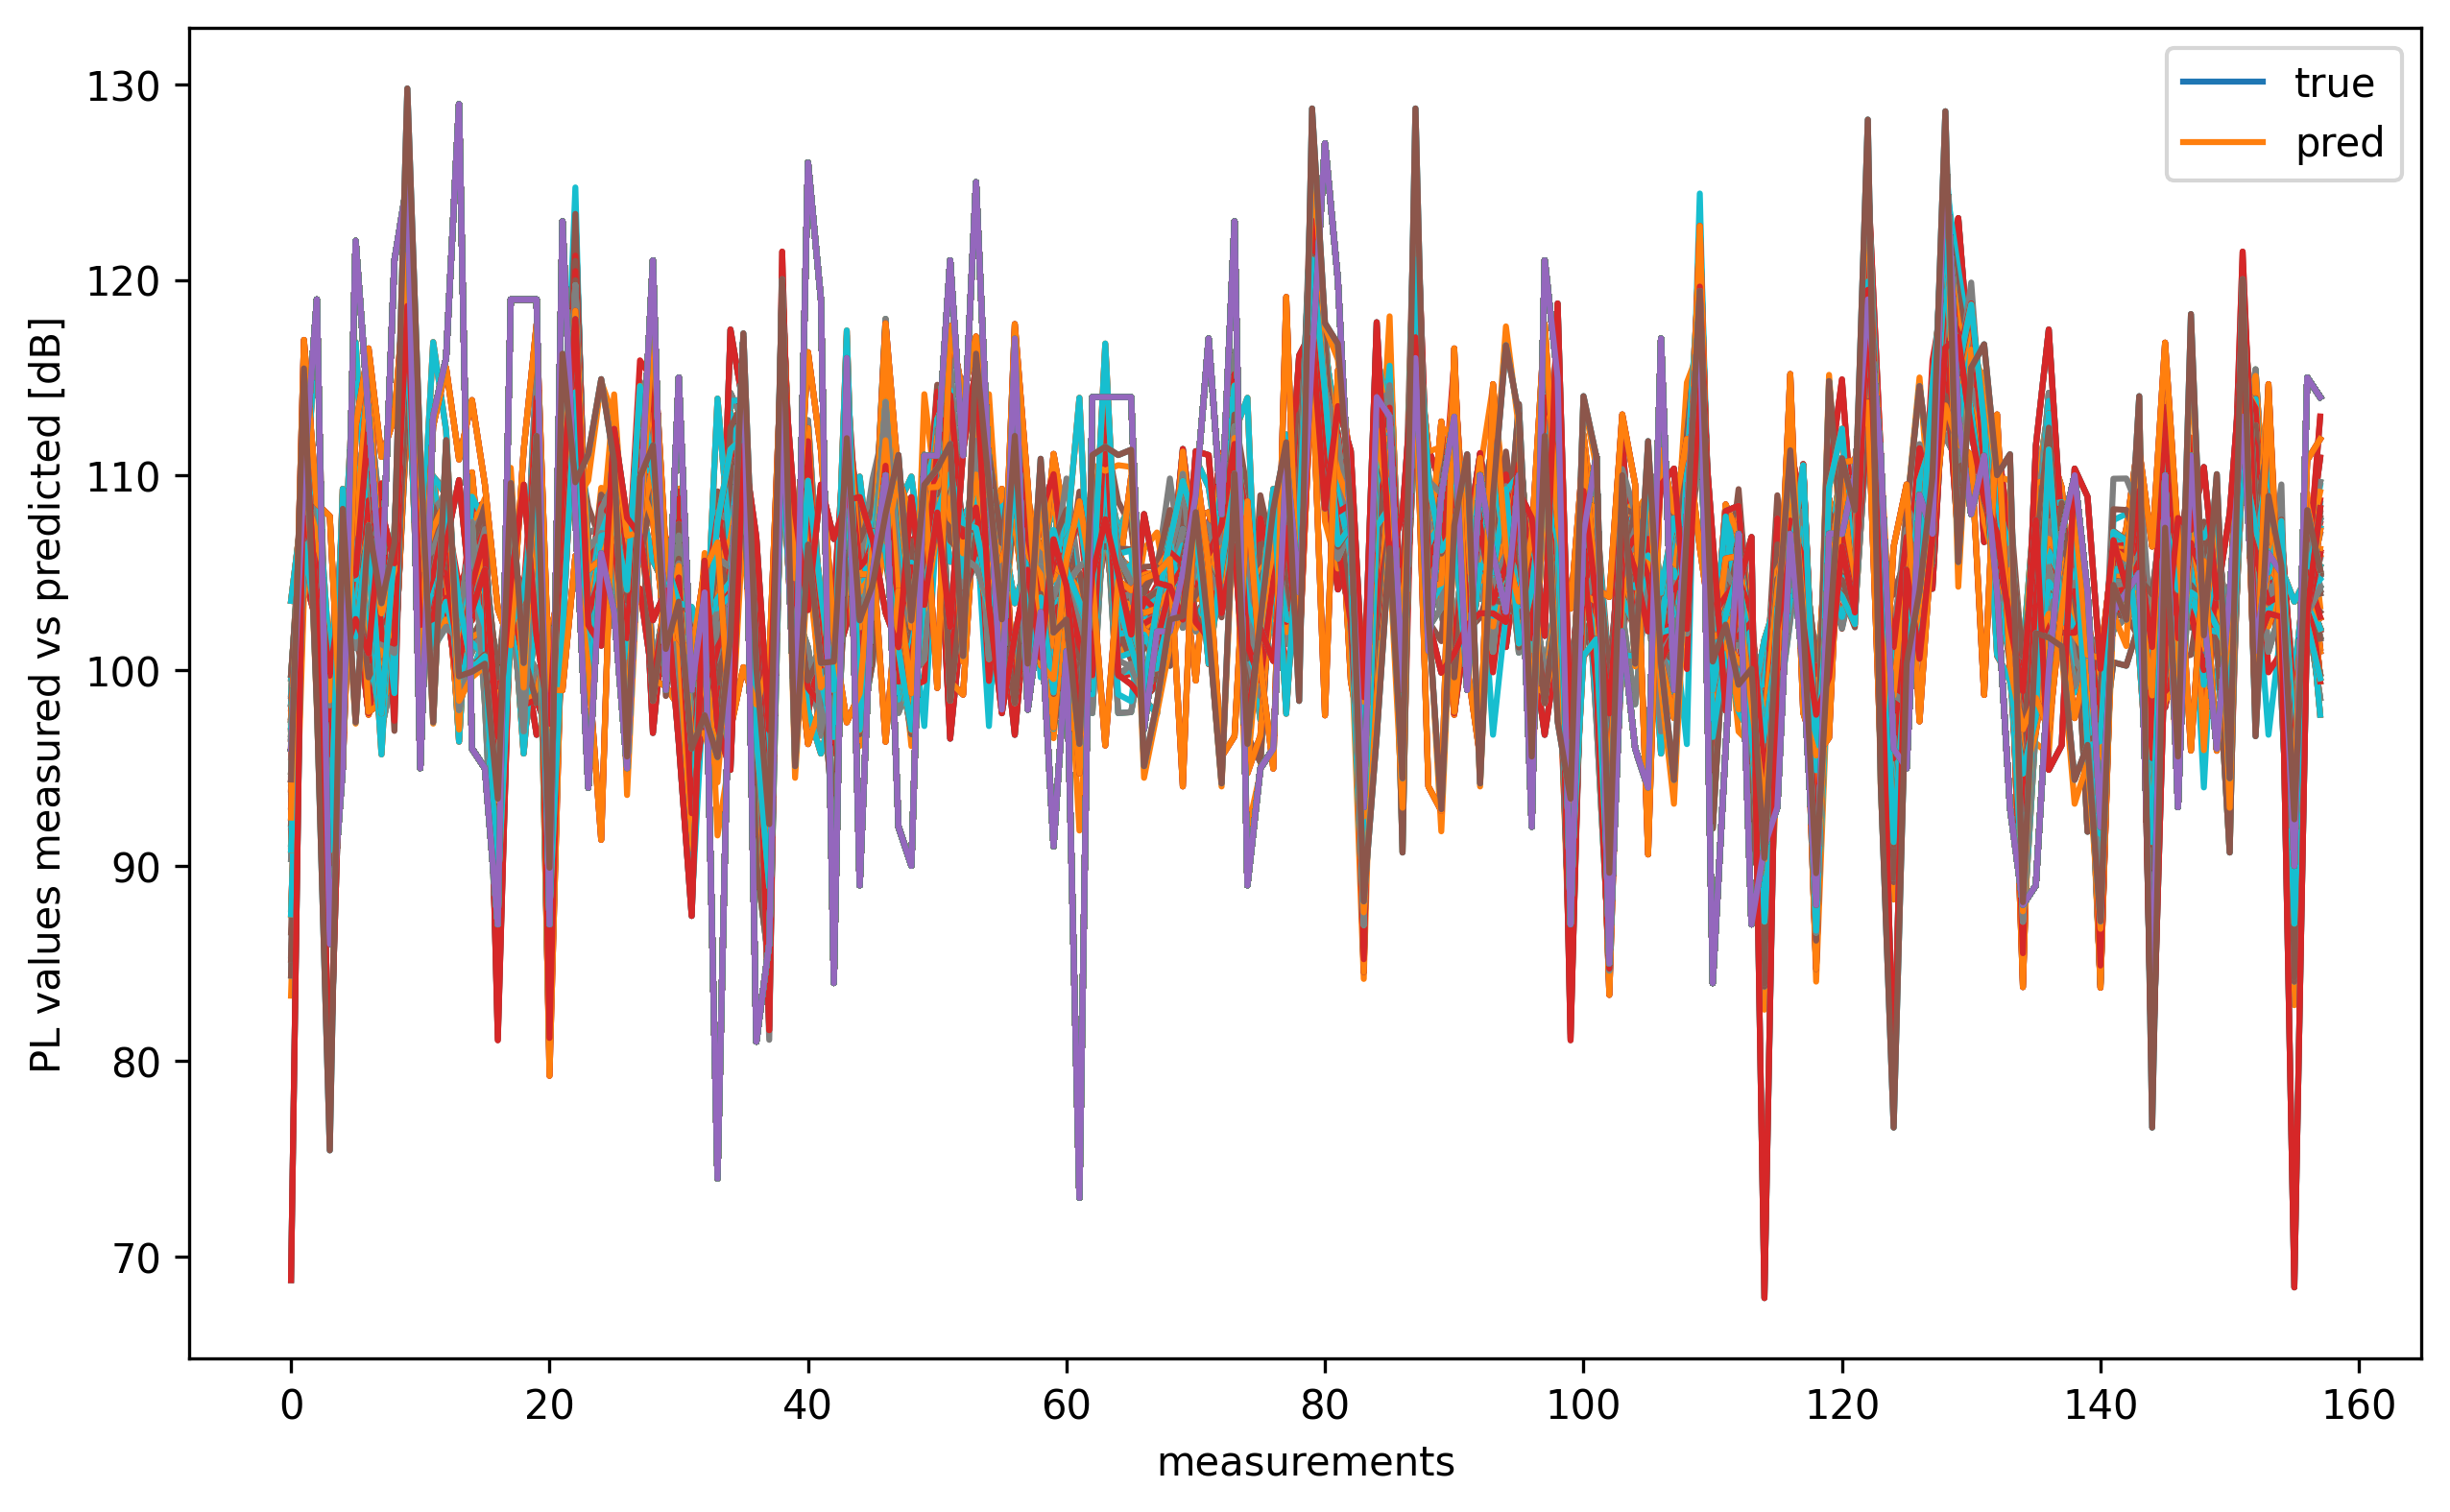

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300


# Store the training and test losses for each grid size for later plotting.
tr_losses = []
te_losses = []
plot_grids = []
plot_steps = []
plot_lambs = []
tr_maes = []
tr_mses = []
tr_mapes = []
tr_r2s = []

train_losses = []
test_losses = []

# Thee parameters for the KAN model.
grids = np.array([5, 8, 10, 15, 20, 30, 40, 50])
steps = np.array([50, 100, 200, 300])
k = 3
lamb = np.array([0.02, 0.002, 0.0002, 0.00002])

for g in range(grids.shape[0]):
    for s in range(steps.shape[0]):
        for l in range(lamb.shape[0]):
            model= KAN(
                width=[3,3,1], 
                grid=grids[g], 
                k=3, 
                seed=42, 
                device=device, 
            ) 
            
            print(f"Grid size: {grids[g]}, steps {steps[s]}, {lamb[l]}")
            results = model.fit(dataset, opt="LBFGS", lamb=lamb[l], steps=steps[s], lamb_entropy=2.)
            
            train_losses += results['train_loss']
            test_losses += results['test_loss']
            #print(np.array(train_losses).mean())

            if not np.isnan(results['train_loss']).any():
                tr_mse, tr_rmse, tr_mae, tr_mape, tr_r2 = eval_kan(model, nan, dataset);
                #te_mse, te_rmse, te_mae, te_mape, te_r2 = eval_kan(model, validation_data);

                plot_grids.append(grids[g])
                plot_steps.append(steps[s])
                plot_lambs.append(lamb[l])
                print(plot_lambs)
                
                tr_losses.append(np.array(train_losses).mean())
                te_losses.append(np.array(test_losses).mean())
                tr_maes.append(tr_mae)
                tr_mses.append(tr_mse)
                tr_mapes.append(tr_mape)
                tr_r2s.append(tr_r2)
